# Title: Predicting the experience of a Minecraft player by using age and hours played through kNN-classification algorithm

- Names: Eva Yarantseva, Ivan Chau, Rihanna Xu
- Student Numbers: 32172173, 53215745, 61625810
- Section: 009-30

## Introduction

## Methods and Results

In [2]:
# loading all of the necessary packages for plotting, predicting:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(ggplot2)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Loading the data (players.csv)

The dataset used in this analysis will be "players.csv". 

In [3]:
# Loading data via absolute pathway

#players <- read_csv("players.csv")

players <- read_csv("https://raw.githubusercontent.com/evayarantseva/dsci-100-2025w1-group-30/main/players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Wrangling and tidying the data for analysis

Our analysis involves using two numerical variables as the predictors, and one categorical as the response. Since we are predicting the experience of the player, we convert the "experience" variable from a character to a factor.

In [4]:
# Tidying the data

# Converting the gender variable into a factor
players <- players |>
    mutate(experience = as.factor(experience))

### Summary of Data

### Visualization of the Data

A kNN-classification algorithm relies on multiple predictors to classify a new observation via straight-line distance between K nearest neighbours. First, we will look at the relationship between the two numeric variables in players.csv (Age and played_hours) to see if the data is suitable for KNN-classification (see: Plot 1).

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


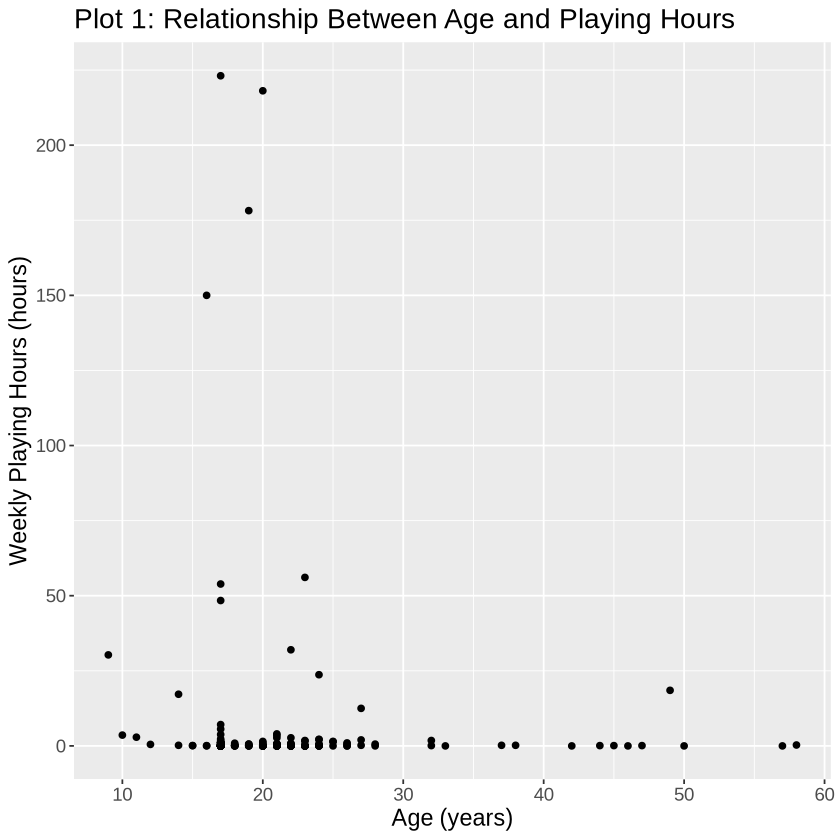

In [5]:
# Visualizing the relationship between age and hours played

ggplot(data = players, aes(x = Age, y = played_hours)) +
    geom_point() +
    labs(
        title = "Plot 1: Relationship Between Age and Playing Hours",
        x = "Age (years)",
        y = "Weekly Playing Hours (hours)",
        ) + 
    theme(text = element_text(size = 14))

Plot 1: the data is concentrated bottom left corner (between ages 10-30, and 0-50 hours). The four outliers that have a range of 150-225 hours played are between 15-20 years old. The players that are older than 30 have less than 25 hours played in the server.

There is an unbalance in data: the K-NN model may have trouble making predictions due to the lack of data on the top right hand side of the plot (people who are older than 30 and play more than 25 hours).

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


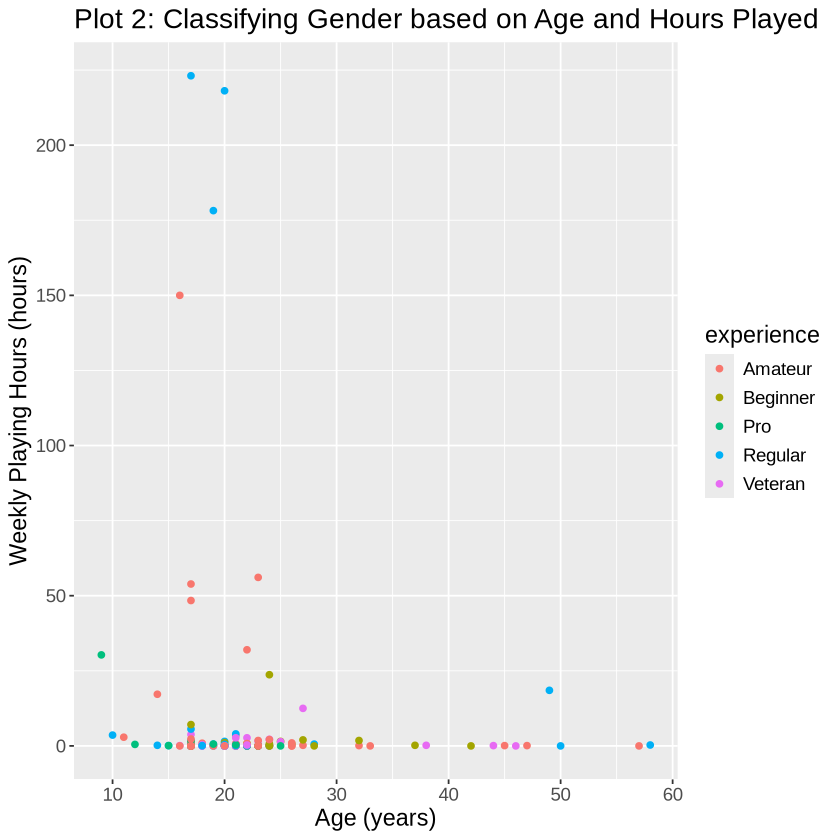

In [6]:
# Seeing if there are clustsers points that indicate experience:

ggplot(data = players, aes(x = Age, y = played_hours, color = experience)) +
    geom_point() +
    labs(
        title = "Plot 2: Classifying Gender based on Age and Hours Played",
        x = "Age (years)",
        y = "Weekly Playing Hours (hours)",
        ) + 
    theme(text = element_text(size = 14)) + 
    scale_fill_brewer(palette = "Set1")

Plot 2: shows the distribution of experience level accross the scatterplot, when plotting age against weekly playing hours. The imbalance in data will make it hard to predict experience level for people who are over the age of 30-40 and play more than 25 hours a week. However, the distribution of experience seems to be fairily equal towards the bottom left corner where there is a larger concentration of data.

### Data Analysis 

The dataset will be split into training (75%, which will be used to train the model) and testing (25%, to measure accruracy of the model) to see if the model is able to accurately classify new observations. A seed will be used to ensure reproducability of results:

In [7]:
# Split into training and testing data

set.seed(3456) 
players<-players|> drop_na()
players_split <- initial_split(players, prop = 0.75, strata = experience)  
players_train <- training(players_split)   
players_test <- testing(players_split)

As seen in Plot 1 and Plot 2, the range of weekly hours played is significantly larger than that of age. Therefore, the predictors will be scaled in a recipe to ensure they are both contributing equally to the classification of new observations:

In [8]:
# Pre-process the variables by scaling them in a recipe

players_recipe <- recipe(experience ~ Age + played_hours , data = players_train) |>
   step_center(all_predictors()) |>
   step_scale(all_predictors())
players_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Centering for: all_predictors()

• Scaling for: all_predictors()



The parameter that needs be determined to optimize the predictive ability of the kNN model is K, the number of neighbours. To find the K number of neighbours, we specify a classification model (ie predicts a categorical variable) that weighs both predictors equally (ie rectangular), and set the number of neighbours to tune() which informs tidymodel that this is the parameter that is going to be found.

In [9]:
# Specifcy model with tuning on the number of neighbours

knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

To test the accuracy of the model using different values of K, the training set will be further split up into v number of "folds" using v-fold cross validation. Each fold will be used as validation once, and as training for the rest. The strata argument will ensure the same proportions of the categories in each training and validation set. The v is set to 5 below:

In [10]:
# Perform a 5-fold cross validation on the training set

fold <- vfold_cv(players_train, v=5, strata = experience)

To find the accuracy for each value of k specifided in the tibble below, we create a workflow for the data analysis. This will allow us to run cross-validation on the training and validation split. The average accuracy of estimate from each validation will be use to determine K. 

In [11]:
# Create the workflow analysis to tune the K parameter

k_vals <- tibble(neighbors = seq(from = 2, to = 15, by = 1))

results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_spec) |>
      tune_grid(resamples = fold, grid = k_vals) |>
      collect_metrics()

accuracies <- results |>
            filter(.metric == "accuracy")

To find K with the highest accuracy we plot the relationship between the two:

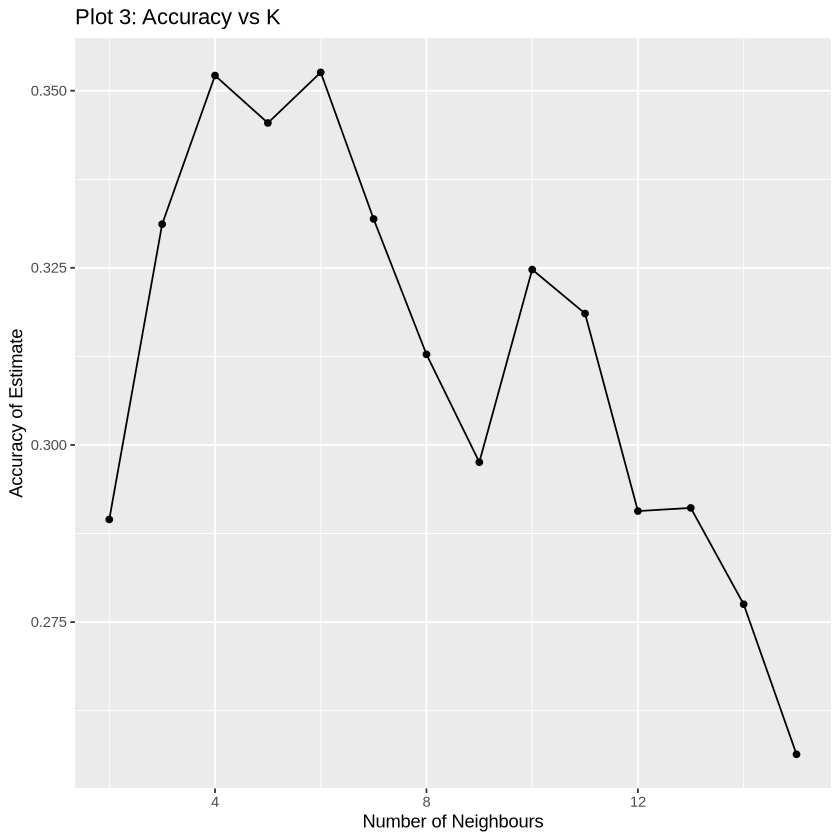

In [12]:
# Plotting the results to find K

cross_val_plot <- accuracies |>
                ggplot(aes(x=neighbors, y=mean)) +
                geom_point() + geom_line() +
                labs(x = "Number of Neighbours", y= "Accuracy of Estimate") +
                ggtitle("Plot 3: Accuracy vs K")
cross_val_plot

Plot 3: there is a peak in accuracy when K = 7 and 8 (at accuracy = 0.375). We will use K = 8 as our optimized parameter to test our classification model. 

Now that we have chosen K = 8, we define our final model and fit our data onto it in a workflow:

In [12]:
# Fitting the final model

players_spec <- nearest_neighbor(weight_func="rectangular", neighbors=8) |>
            set_engine("kknn") |>
            set_mode("classification")

players_fit <- workflow() |>
          add_recipe(players_recipe) |>
          add_model(players_spec) |>
          fit(data = players_train)

To see if how our model performed, we test our model using the testing portion of the dataset (players_test), and quantify the predictive ability of the model by finding the accuracy. We can also see how myc

In [13]:
# Testing the model on the dataset

players_predictions <- predict(players_fit, players_test) |>
                    bind_cols(players_test)

players_metrics <- players_predictions |>
                metrics(truth = experience, estimate = .pred_class)

players_conf_mat <- players_predictions |>
                conf_mat(truth = experience, estimate = .pred_class)


players_metrics
players_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.22000000
kap,multiclass,-0.07556536


          Truth
Prediction Amateur Beginner Pro Regular Veteran
  Amateur        7        7   3       5       8
  Beginner       1        2   0       0       1
  Pro            1        0   0       0       0
  Regular        1        0   0       0       0
  Veteran        6        1   1       4       2

### Visualization of Analysis

## Discussion

## References